# Inference testing

## Load modules

In [40]:
using Pkg
Pkg.activate(".")
#Pkg.update()

  Activating project at `~/Desktop/julia_codes/SmallCouplingDynamicCavity.jl/notebook`


In [ ]:
using SmallCouplingDynamicCavity
using Plots, LaTeXStrings
using Graphs, GraphRecipes
using Distributions, Random

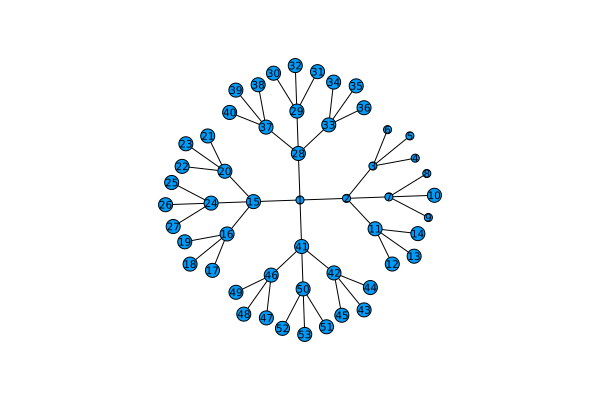

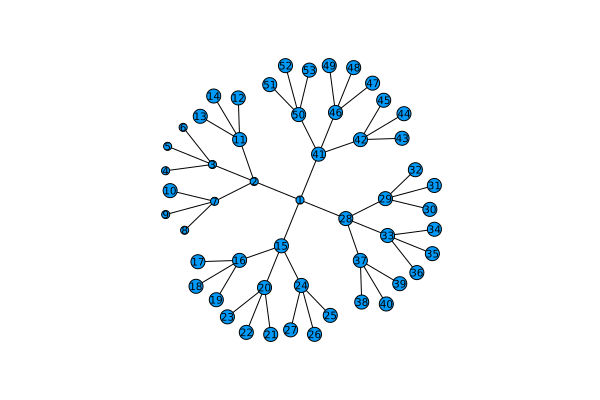

In [ ]:
V, E = bethe_lattice(4, 3, root1=true)

V, E = generate_bethe_lattice(4, 3)
G = SimpleGraph(length(V), 0)
for e in E
    add_edge!(G, e[1], e[2])
end
display(graphplot(G, names=vertices(G), edgecolor=:black,curves=false, nodeshape=:circle, markersize =.15))


function generate_bethe_lattice(z::Int, tmax::Int)
    @assert z > 1 "Degree z must be greater than 1."
    @assert tmax >= 1 "Maximum depth tmax must be at least 1."
    
    # Initialize vertex and edge lists
    V = [1]  # Start with root node as vertex 1
    E = Vector{Vector{Int}}()
    
    # Helper function to recursively add vertices and edges
    function add_children(node, depth, next_vertex)
        if depth > tmax
            return next_vertex  # Stop if max depth is reached
        end
        children_count = z - 1  # Number of children each node has, except root
        if node == 1 children_count = z end  # Root has z children

        for i in 1:children_count
            next_vertex += 1  # Increment to get new vertex
            push!(V, next_vertex)
            push!(E, [node, next_vertex])
            # Recurse to add children of this new node
            next_vertex = add_children(next_vertex, depth + 1, next_vertex)
        end
        return next_vertex
    end
    
    # Start recursion from the root node at depth 1
    add_children(1, 1, 1)
    
    return V, E
end


V, E = generate_bethe_lattice(4, 3)
G = SimpleGraph(length(V), 0)
for e in E
    add_edge!(G, e[1], e[2])
end
display(graphplot(G, names=vertices(G), edgecolor=:black,curves=false, nodeshape=:circle, markersize =.15))



In [19]:
function sort_by_infection_time(X, T, NV)
    inf_tuples = Dict()
    first_time_inf = ones(Int, NV).*(T+1)
    for i=1:NV
        t1 = 0
        t2 = 0
        inf = false
        for t=0:T
            if X[i,t+1]==1.0 && !inf
                t1 = t
                inf = true
            elseif X[i,t+1]==2.0 && inf
                t2 = t
                if !haskey(inf_tuples, i)
                    merge!(inf_tuples, Dict(i=>[(t1,t2)]))
                    first_time_inf[i] = t1
                else
                    push!(inf_tuples[i],(t1,t2))
                end
                inf = false
            else
                continue
            end
        end
        if inf
            if !haskey(inf_tuples, i)
                merge!(inf_tuples, Dict(i=>[(t1,T)]))
                first_time_inf[i] = t1
            else
                push!(inf_tuples[i],(t1,T))
            end
        end
    end
    #display(first_time_inf)
    perm = sortperm(first_time_inf)
    
    return inf_tuples, invperm(perm), perm
end

sort_by_infection_time (generic function with 1 method)

## Graph generation

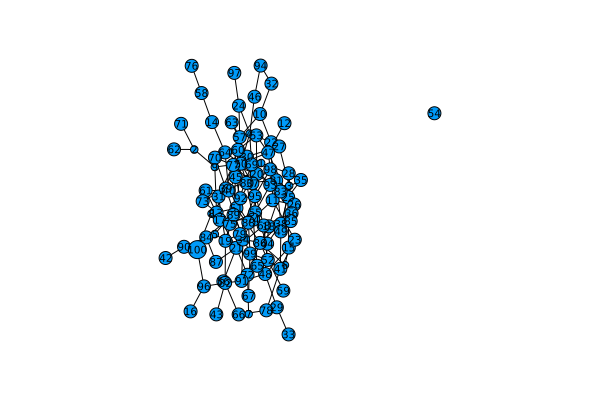

In [20]:
NV = 100 # number of graph vertices
k = 3 # average degree

#genrate an Erdos-Renyi random graph with average connectivity k
rng = Xoshiro(1234)
G = erdos_renyi(NV, k/NV, rng=rng)

# generate a random tree
#G = uniform_tree(NV)

# generate a Watts-Strogatz small world random graph with average connectivity k
#G = watts_strogatz(NV, ceil(Int,k), 0.1, remove_edges = true)

# Graph plotting
display(graphplot(G, names=vertices(G), edgecolor=:black,curves=false, nodeshape=:circle, markersize =.15))

## - SIRS: model simulation

### System parameter definition and simulation

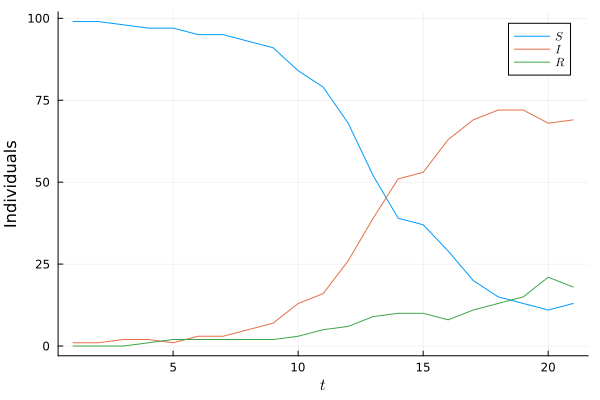

sources: [15]


In [36]:
# define the constants
T = 20 # total time
fₚ = 0.0 # false-positive rate
fₙ = 0.0 # false-negative rate
γ = 1/NV # Patient zero probability
λ₀ = 0.3 # Infection rate
r₀ = 0.05 # Recovery rate
σ₀ = 0.1 # Immunity rate
ε_autoinf = 1e-10 # Self-infection rate

# define the observation probability
function obsprob(Ob, x)
    if Ob == -1
        return 1.0
    else
        return Float64(Ob == x)
    end
end

# constant infection probability
λ = zeros(NV, NV, T+1)
for e in edges(G)
    λ[src(e), dst(e), :] = ones(T+1) * λ₀
    λ[dst(e), src(e), :] = ones(T+1) * λ₀
end

# define de epidemic model
infectionmodel = SIRS(ε_autoinf, r₀, σ₀, NV, T)
model = EpidemicModel(infectionmodel, G, T, log.(1 .- λ))

# epidemic simulation
config = sim_epidemics(model, γ=γ, rng=rng)
inf_tuples, invperm_sort, perm_sort = sort_by_infection_time(config, T, NV)

isource = findall(x->x==1.0, config[:,1])
println("sources: $(isource)")

# infected individuals over time
nrI = dropdims(sum(map(x->Float64(x==1.0),config), dims = 1), dims = 1)
nrS = dropdims(sum(map(x->Float64(x==0.0),config), dims = 1), dims = 1)
nrR = dropdims(sum(map(x->Float64(x==2.0),config), dims = 1), dims = 1)
display(plot([nrS nrI nrR], xlabel = L"t", ylabel = "Individuals", label = [L"S" L"I" L"R"]))

### Generation of observations

In [37]:
Nobs = ceil(Int,NV*.75) # number of observations

# generate observations
obsmat = ones(nv(G), T+1) * Int8(-1)
obslist = []
for (iₗ, τₗ) in sample(collect(zip(1:NV,ones(Int, NV)*ceil(Int, T*.51))), Nobs, replace = false) 
    obsmat[iₗ, τₗ] = config[iₗ, τₗ]
    push!(obslist, (iₗ, τₗ-1))
end
    
# insert the observations into the model structure
model.obsmat .= obsmat

println(obslist)

Any[(58, 10), (25, 10), (40, 10), (99, 10), (100, 10), (36, 10), (95, 10), (23, 10), (52, 10), (29, 10), (41, 10), (93, 10), (87, 10), (38, 10), (51, 10), (65, 10), (13, 10), (84, 10), (2, 10), (82, 10), (3, 10), (39, 10), (4, 10), (24, 10), (88, 10), (72, 10), (47, 10), (28, 10), (76, 10), (83, 10), (54, 10), (10, 10), (64, 10), (37, 10), (94, 10), (63, 10), (59, 10), (17, 10), (98, 10), (92, 10), (53, 10), (73, 10), (80, 10), (44, 10), (71, 10), (18, 10), (69, 10), (78, 10), (42, 10), (14, 10), (81, 10), (74, 10), (5, 10), (70, 10), (61, 10), (55, 10), (75, 10), (22, 10), (68, 10), (45, 10), (21, 10), (16, 10), (48, 10), (57, 10), (7, 10), (34, 10), (85, 10), (32, 10), (91, 10), (62, 10), (35, 10), (8, 10), (49, 10), (6, 10), (60, 10)]


## Inference SCDC -- autoinfection, $\mu$ cutoff

In [38]:
# computational constants
epsconv = 5e-15 # convergence threshold
maxiter = Int(5e2) # max number of iterations
damp = 0.0 # damping factor
μ_cutoff = -1.0

# callback function
function report(nodes,iter,ε) 
    println("i = ", iter,  " ε = ", ε)
end

nodes = run_SCDC(model, obsprob, γ, maxiter, epsconv, damp, μ_cutoff = μ_cutoff, callback = report)

marg_prob_sorted = zeros(NV, T+1, 3)
for inode in nodes
#    marg_prob_sorted[inode.i,:,:] .= inode.marg.m'
    marg_prob_sorted[invperm_sort[inode.i],:,:] .= inode.marg.m'
end
 #marg_prob_sorted = marg_prob_sorted[perm_sort,:,:];

i = 1 ε = 1.0
i = 2 ε = 0.9064317538395479
i = 3 ε = 0.8341186467262455
i = 4 ε = 0.7851599974533775
i = 5 ε = 0.813740007350056
i = 6 ε = 0.4411048364872079
i = 7 ε = 0.27426447980637725
i = 8 ε = 0.15785780559345253
i = 9 ε = 0.1312870621617519
i = 10 ε = 0.08773327876539705
i = 11 ε = 0.01475037113966321
i = 12 ε = 0.018695852223892584
i = 13 ε = 0.007389746291079968
i = 14 ε = 0.004912247991065488
i = 15 ε = 0.0018464814124095896
i = 16 ε = 0.0010286339297373992
i = 17 ε = 0.0012120645686014564
i = 18 ε = 0.0005487465693115312
i = 19 ε = 0.00020610452798214274
i = 20 ε = 0.00028973864211689904
i = 21 ε = 6.75039729408633e-5
i = 22 ε = 4.0205342571875136e-5
i = 23 ε = 1.8822267774165624e-5
i = 24 ε = 1.0067076990749602e-5
i = 25 ε = 1.359013424334643e-5
i = 26 ε = 5.036772408595347e-6
i = 27 ε = 1.9842404312964135e-6
i = 28 ε = 2.3118703512681194e-6
i = 29 ε = 1.4941432777693109e-6
i = 30 ε = 2.8919345146372066e-7
i = 31 ε = 6.36207532989097e-7
i = 32 ε = 1.1825157747447079e-7
i = 3

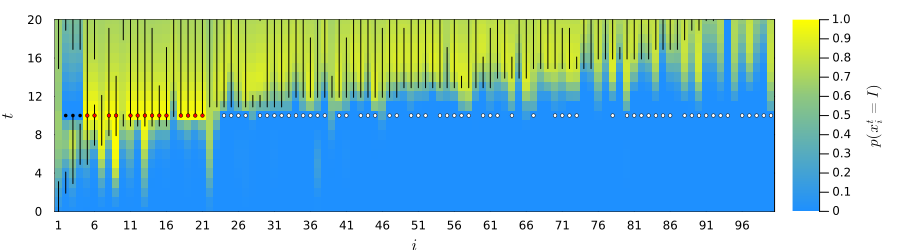

In [39]:
resize_factor = 1.0

cg = cgrad([:dodgerblue, :yellow], 0.6)

plI = heatmap(1:NV, 0:T, marg_prob_sorted[:,:,2]', c=cg, xlabel=L"i", ylabel=L"t", colorbar_title=L"p(x_i^t=I)", yrange=(0,T), xticks=1:5:NV, framestyle = :box)

for (i, inf_time_list) in inf_tuples
    for inf_time in inf_time_list
        plot!(plI, [invperm_sort[i],invperm_sort[i]], [inf_time[1]-0.1,inf_time[2]+0.1], c=:black, label="", lw=1)
    end
end

cols = [:white, :red, :black]
for (i,t) in obslist
    scatter!(plI, [invperm_sort[i]], [t], ms=2, msc=:black, c=cols[ceil(Int,config[i,t+1])+1], label="")
end

plot!(plI, yticks=0:(T÷5):T, widen=false, margin=3Plots.mm, size=(900,250).*resize_factor)

display(plI)